# Panoptic Segmentation Model Finetuning

In this workflow, we will finetune a panoptic segmentation model using the refined Panoptils dataset that is available in [histolytics-hub](https://huggingface.co/datasets/histolytics-hub/panoptils_refined). See the original dataset in [https://sites.google.com/view/panoptils/](https://sites.google.com/view/panoptils/)

In [1]:
# Some installations
# !pip install torchdata
# !pip install tables

In [3]:
from platform import python_version

import torch
import albumentations as A
import cellseg_models_pytorch

print("torch version:", torch.__version__)
print("albumentations version:", A.__version__)
print("cellseg_models_pytorch version:", cellseg_models_pytorch.__version__)
print("python version:", python_version())

torch version: 2.7.0+cu126
albumentations version: 2.0.6
cellseg_models_pytorch version: 0.1.26
python version: 3.12.3


## Load the Panoptils dataset from the Hugging Face Hub

The code below demonstrates how to load and process the Panoptils dataset from the Hugging Face Hub. This dataset is stored in a compressed, byte-encoded format that requires proper decoding before use.

### Understanding the data format
The Panoptils dataset is stored in the Hugging Face Hub as a parquet file containing byte-encoded PNG images. This format offers efficient storage and distribution but requires a decoding step before the data can be visualized or used for model training.

Each record in the dataset contains multiple byte-encoded fields:

- image: The original histology image
- inst: Instance segmentation mask where each object has a unique ID
- type: Cell type classification mask
- sem: Semantic segmentation mask for tissue regions

The data classes are:

```
nuclei_classes = {
    "background": 0,
    "neoplastic": 1,
    "stromal": 2,
    "inflammatory": 3,
    "epithelial": 4,
    "other": 5,
    "unknown": 6,
}

tissue_classes = {
    "background": 0,
    "tumor": 1,
    "stroma": 2,
    "epithelium": 3,
    "junk/debris": 4,
    "blood": 5,
    "other": 6,
}
```

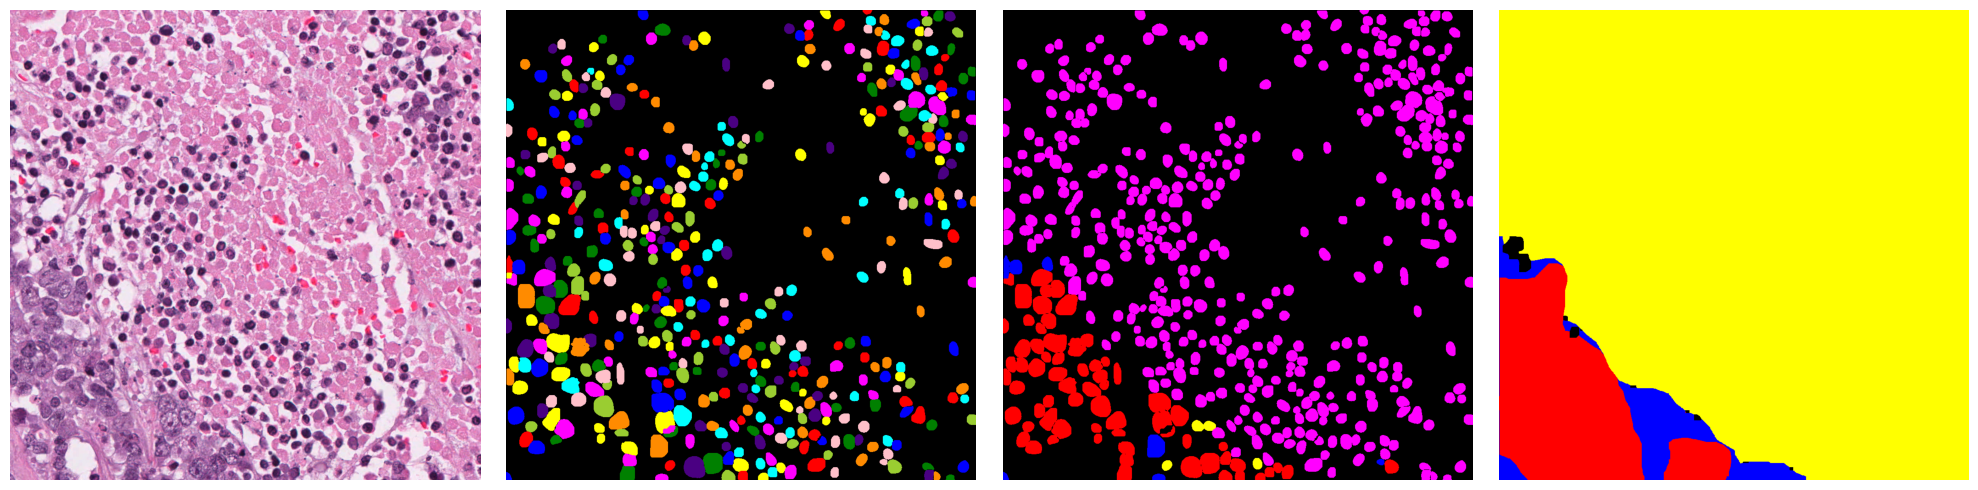

In [4]:
import warnings
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

from datasets import load_dataset
from PIL import Image
from skimage.color import label2rgb

warnings.filterwarnings("ignore")


# for decoding PNG bytes to numpy array
def png_bytes_to_array(png_bytes):
    img = Image.open(io.BytesIO(png_bytes))
    return np.array(img)


# Load the dataset from Hugging Face Hub
ds = load_dataset("histolytics-hub/panoptils_refined", split="train")

# convert to pandas df
df = ds.with_format("pandas")[:]

# Example: decode one row
row = df.iloc[1]
image = png_bytes_to_array(row["image"])
inst_mask = png_bytes_to_array(row["inst"])
type_mask = png_bytes_to_array(row["type"])
sem_mask = png_bytes_to_array(row["sem"])

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image)
axes[1].imshow(label2rgb(inst_mask, bg_label=0))
axes[2].imshow(label2rgb(type_mask, bg_label=0))
axes[3].imshow(label2rgb(sem_mask, bg_label=0))

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

## Split the panoptils data into training and validation sets

The cell below creates a single train-validation split (80%-20%) while ensuring all patches from the same slide stay together to avoid data leaking.

In [5]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df, groups=df["slide_name"]))

df_train = df.iloc[train_idx]
df_val = df.iloc[val_idx]
df_train.head()

,slide_name,hospital,sample,image,inst,type,sem
0,TCGA-A1-A0SK-DX1,A1,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.250...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,TCGA-A1-A0SK-DX1,A1,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.250...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,TCGA-A1-A0SK-DX1,A1,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.250...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,TCGA-A1-A0SK-DX1,A1,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.250...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4,TCGA-A1-A0SK-DX1,A1,TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.250...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


## Create H5 files for training and validation

Working directly with the byte-encoded PNG images requires continuous on-the-fly decoding during training. By pre-decoding images and masks into H5 format, we eliminate this repetitive computational overhead, significantly accelerating data loading.

In [ ]:
import tables as tb
import albumentations as A

from pathlib import Path
from histolytics.utils import H5Handler
from cellseg_models_pytorch.inference.predictor import Predictor
from cellseg_models_pytorch.wsi.tiles import _pad_tile
from tqdm import tqdm

warnings.filterwarnings("ignore")

# we will apply some simple augmentations to the patches
img_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.33),
        A.VerticalFlip(p=0.33),
    ]
)

# we'll save the h5 file in a directory in the home folder
h5handler = H5Handler()
save_dir = Path.home() / "panoptils_refined"
save_dir.mkdir(parents=True, exist_ok=True)


# Helper function to patch the images and to create H5 files from the patches
def create_h5(df: pd.DataFrame, fold: str, stride: int, patch_size: tuple):
    fname = save_dir / f"panoptils_{fold}_p{patch_size[0]}_{stride}.h5"
    h5 = tb.open_file(fname, "w")
    h5handler.init_img(h5, patch_size)
    h5handler.init_mask(h5, "inst_mask", patch_size)
    h5handler.init_mask(h5, "type_mask", patch_size)
    h5handler.init_mask(h5, "sem_mask", patch_size)

    try:
        for i, row in tqdm(
            df.iterrows(), total=len(df), desc=f"Processing {fold} patches"
        ):
            image = png_bytes_to_array(row["image"])
            inst_mask = png_bytes_to_array(row["inst"])
            type_mask = png_bytes_to_array(row["type"])
            sem_mask = png_bytes_to_array(row["sem"])

            data = np.concatenate(
                [
                    image,
                    inst_mask[..., None],
                    type_mask[..., None],
                    sem_mask[..., None],
                ],
                axis=2,
            )
            slices, pady, padx = Predictor._get_slices(
                stride, patch_size, image.shape[:2]
            )

            padx, modx = divmod(padx, 2)
            pady, mody = divmod(pady, 2)
            padx += modx
            pady += mody

            for yslice, xslice in slices:
                x_i = _pad_tile(data[yslice, xslice, ...], shape=patch_size, fill=0)
                x_i = img_transforms(image=x_i)["image"]  # apply flips
                im_i = x_i[..., :3]
                inst_i = x_i[..., 3]
                type_i = x_i[..., 4]
                sem_i = x_i[..., 5]
                h5handler.append_array(h5, im_i[None, ...], "image")
                h5handler.append_array(h5, inst_i[None, ...], "inst_mask")
                h5handler.append_array(h5, type_i[None, ...], "type_mask")
                h5handler.append_array(h5, sem_i[None, ...], "sem_mask")

        h5.close()
    except Exception as e:
        h5.close()
        raise e


# Create H5 files for train and validation sets
create_h5(df_train, "train", stride=224, patch_size=(224, 224))
create_h5(df_val, "val", stride=224, patch_size=(224, 224))

Processing val patches: 100%|██████████| 236/236 [00:15<00:00, 14.81it/s]


## Visualize patches from H5 train dataset

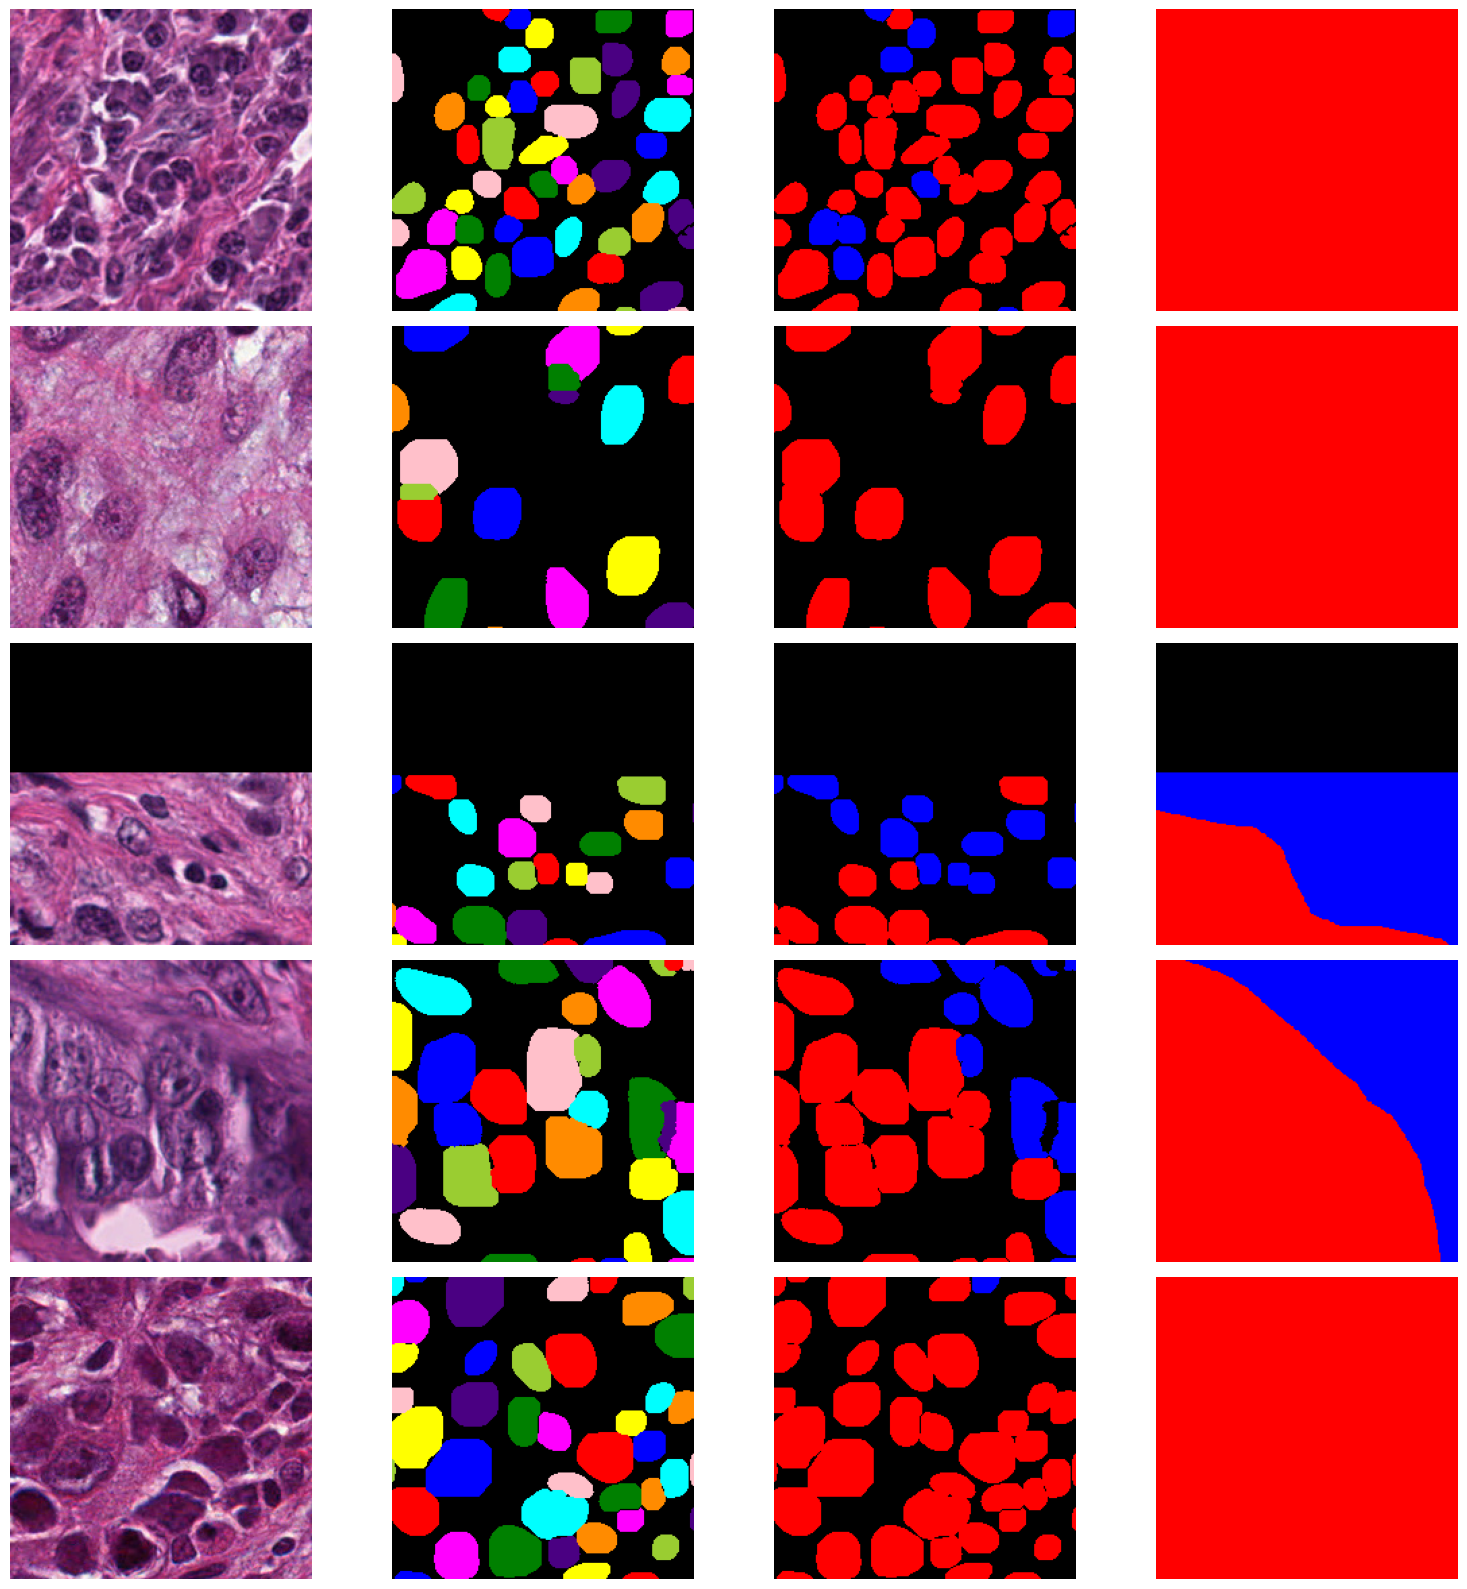

In [9]:
import matplotlib.pyplot as plt

# Open the H5 file for train patches
h5_train_path = save_dir / "panoptils_train_p224_224.h5"
with tb.open_file(h5_train_path, "r") as h5:
    n_patches = h5.root.image.shape[0]
    idxs = np.random.choice(n_patches, size=5, replace=False)
    fig, axes = plt.subplots(5, 4, figsize=(16, 16))
    for i, idx in enumerate(idxs):
        image = h5.root.image[idx]
        inst = h5.root.inst_mask[idx]
        type_ = h5.root.type_mask[idx]
        sem = h5.root.sem_mask[idx]
        axes[i, 0].imshow(image.astype(np.uint8))
        axes[i, 1].imshow(label2rgb(inst, bg_label=0))
        axes[i, 2].imshow(label2rgb(type_, bg_label=0))
        axes[i, 3].imshow(label2rgb(sem, bg_label=0))
        for j in range(4):
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

## Create the Dataloader class for training and validation

Instead of the common torch `DataLoader`, we will be using `torchdata.nodes` to create our dataloader API, which offers significant performance advantages. The NodesDataLoader implementation in the next cell creates an efficient data loading pipeline for our training and validation purposes.

In [2]:
import sys
import time
from pathlib import Path
from typing import Dict, List

import albumentations as A
import numpy as np
import torch
import torch.nn.functional as F
import torchdata.nodes as tn
from torch.utils.data import Dataset, RandomSampler, SequentialSampler
from safetensors.torch import save_model


def collate(x: List[Dict[str, np.ndarray]]) -> Dict[str, np.ndarray]:
    return {key: torch.stack([d[key] for d in x]) for key in x[0].keys()}


class MapAndCollate:
    def __init__(self, dataset: Dataset):
        self.dataset = dataset

    def __call__(self, batch_of_indices: List[int]) -> Dict[str, np.ndarray]:
        batch = [self.dataset[i] for i in batch_of_indices]
        return collate(batch)


# To keep things simple, let's assume that the following args are provided by the caller
def NodesDataLoader(
    dataset: Dataset,
    batch_size: int,
    shuffle: bool,
    num_workers: int,
    pin_memory: bool,
    drop_last: bool,
):
    # Assume we're working with a map-style dataset
    assert hasattr(dataset, "__getitem__") and hasattr(dataset, "__len__")

    sampler = RandomSampler(dataset) if shuffle else SequentialSampler(dataset)
    node = tn.SamplerWrapper(sampler)
    node = tn.Batcher(node, batch_size=batch_size, drop_last=drop_last)

    map_and_collate = MapAndCollate(dataset)
    node = tn.ParallelMapper(
        node,
        map_fn=map_and_collate,
        num_workers=num_workers,
        method="process",  # Set this to "thread" for multi-threading
        in_order=True,
    )

    if pin_memory:
        node = tn.PinMemory(node)
    node = tn.Prefetcher(node, prefetch_factor=num_workers * 2)

    return tn.Loader(node)


## Initialize the model, augmentations, datasets, dataloaders, optimizer, and loss functions

Here we will initialize the model, augmentations, datasets, dataloaders, optimizer, and loss functions.

**Model**
- We will be using the `CellposePanoptic` model with EfficientNet-B5 backbone from the [pytorch-image-models](https://github.com/huggingface/pytorch-image-models) library.

**Transformations**
- During training we will apply random horizontal and vertical flips, and the [StronAugment](https://arxiv.org/abs/2206.15274) pipeline
- The nuclei instance masks are transformed with the `CellposeTransform` that convert the masks into regressable heat diffusion flow maps. See the [Cellpose paper](https://www.nature.com/articles/s41592-020-01018-x)

**Losses for different outputs**
- We will use the `MSELoss` for the regression loss of the heat diffusion flow maps.
- For the semantic nuclei type loss, we will use a `JointLoss`, consisting of `CELoss`, and `DiceLoss`. Additionally we will use `apply_sd=True` in the CELoss that activates spectral decoupling regularization when computing the loss. See [this paper](https://arxiv.org/abs/2103.17171) for more details.
- For the semantic tissue type loss, we will use the same `JointLoss` as above.
- All these losses will be combined into a single `MultiTaskLoss` that will be used to train the model.

In [4]:
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

from histolytics.torch_datasets.h5dataset import DatasetH5
from histolytics.losses import CELoss, DiceLoss, JointLoss, MultiTaskLoss
from histolytics.models.cellpose_panoptic import CellposePanoptic
from histolytics.transforms import (
    AlbuStrongAugment,
    CellposeTransform,
    MinMaxNormalization,
    ApplyEach,
)

# panoptils (refined) classes
nuclei_classes = {
    "background": 0,
    "neoplastic": 1,
    "stromal": 2,
    "inflammatory": 3,
    "epithelial": 4,
    "other": 5,
    "unknown": 6,
}

tissue_classes = {
    "background": 0,
    "tumor": 1,
    "stroma": 2,
    "epithelium": 3,
    "junk/debris": 4,
    "blood": 5,
    "other": 6,
}


# Quick wrapper for MSE loss to make it fit the JointLoss API
class MSELoss(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()

    def forward(
        self, yhat: torch.Tensor, target: torch.Tensor, **kwargs
    ) -> torch.Tensor:
        return F.mse_loss(yhat, target, reduction="mean").float()


batch_size = 8
in_keys = ("image", "sem_mask", "inst_mask", "type_mask")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# init  CellposePanoptic model
cpose_panoptic = CellposePanoptic(
    n_nuc_classes=len(nuclei_classes),
    n_tissue_classes=len(tissue_classes),
    enc_name="efficientnet_b5",  # you can change this to any supported encoder
    enc_pretrain=True,
)
model = cpose_panoptic.model.to(device)

# init training transforms
img_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.33),
        A.VerticalFlip(p=0.33),
        AlbuStrongAugment(),
        MinMaxNormalization(),
    ]
)

inst_transforms = ApplyEach([CellposeTransform(deduplicate=False)], as_list=True)

# init val dataset and dataloader
ds_train = DatasetH5(
    Path().home() / "panoptils_refined" / "panoptils_train_p224_224.h5",
    img_key="image",
    inst_keys=["inst_mask"],
    mask_keys=["type_mask", "sem_mask"],
    transforms=img_transforms,
    inst_transforms=inst_transforms,
)

loader_train = NodesDataLoader(
    ds_train,
    batch_size,
    shuffle=False,
    num_workers=batch_size,
    pin_memory=True,
    drop_last=True,
)
# init train dataset and dataloader
ds_val = DatasetH5(
    Path().home() / "panoptils_refined" / "panoptils_val_p224_224.h5",
    img_key="image",
    inst_keys=["inst_mask"],
    mask_keys=["type_mask", "sem_mask"],
    transforms=img_transforms,
    inst_transforms=inst_transforms,
)

loader_val = NodesDataLoader(
    ds_val,
    batch_size,
    shuffle=True,
    num_workers=batch_size,
    pin_memory=True,
    drop_last=True,
)

# init training multi-task loss
# The losses are defined for each task, and the weights are set for each task.
losses = {
    "cellpose": JointLoss([MSELoss()]),
    "type_mask": JointLoss([CELoss(apply_sd=True), DiceLoss()]),
    "sem_mask": JointLoss([CELoss(apply_sd=True), DiceLoss()]),
}
loss_weights = {"cellpose": 1.0, "type_mask": 1.0, "sem_mask": 2.0}
multitask_loss = MultiTaskLoss(losses, loss_weights=loss_weights).to(device)

# optimizer and lr scheduler
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0001)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=1000, eta_min=0, last_epoch=-1)

## Start training the model

We will train/finetune the model with a simple train loop. For the sake of the example, we will train only for 1 epoch.

In [ ]:
n_epochs = 1
progress_freq = 100

total = int(np.ceil(len(ds_train) / batch_size))
save_dir = Path.home() / "panoptils_refined"


print("Start training, num epochs:", n_epochs, file=sys.stderr)
for epoch in range(n_epochs):
    # Train loop
    model.train()
    total_loss = 0
    num_batches = 0
    start = time.perf_counter()
    for i, batch in enumerate(loader_train):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        soft_masks = model(batch.pop("image"))
        targets = {
            "cellpose": batch["inst_mask_cellpose"],
            "type_mask": batch["type_mask"],
            "sem_mask": batch["sem_mask"],
        }
        yhats = {
            "cellpose": soft_masks["nuc"].aux_map,
            "type_mask": soft_masks["nuc"].type_map,
            "sem_mask": soft_masks["tissue"].type_map,
        }
        loss = multitask_loss(yhats, targets)

        # skip batches where loss goes to nan
        if torch.isnan(loss):
            print("NaN loss encountered, skipping batch")
            continue

        loss.backward()
        optimizer.step()

        # compute total loss
        total_loss += loss.item()
        num_batches += 1
        avg_loss = total_loss / num_batches

        if i % progress_freq == 0:
            iter_time = time.perf_counter() - start
            mins = int(iter_time // 60)
            secs = int(iter_time % 60)
            throughput = i * batch_size / iter_time
            estimated_time_left = (total - i) * batch_size / (throughput + 0.001)
            est_mins = int(estimated_time_left // 60)
            est_secs = int(estimated_time_left % 60)
            tmsg = f"b {i}/{total}, {mins}min {secs}s/{est_mins}min {est_secs}s, avg throughput: {round(throughput, 2)} img/sec "
            lmsg = f"avg loss: {round(avg_loss, 4)}"
            print(f"epoch {epoch}, {tmsg}, {lmsg}", file=sys.stderr)

    # Validation loop
    model.eval()
    val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for val_batch in loader_val:
            val_batch = {k: v.to(device) for k, v in val_batch.items()}
            val_soft_masks = model(val_batch.pop("image"))
            val_targets = {
                "cellpose": val_batch["inst_mask_cellpose"],
                "type_mask": val_batch["type_mask"],
                "sem_mask": val_batch["sem_mask"],
            }
            val_yhats = {
                "cellpose": val_soft_masks["nuc"].aux_map,
                "type_mask": val_soft_masks["nuc"].type_map,
                "sem_mask": val_soft_masks["tissue"].type_map,
            }
            vloss = multitask_loss(val_yhats, val_targets)
            if not torch.isnan(vloss):
                val_loss += vloss.item()
                val_batches += 1

    if val_batches > 0:
        avg_val_loss = val_loss / val_batches
        print(
            f"epoch {epoch}, validation avg loss: {round(avg_val_loss, 4)}",
            file=sys.stderr,
        )

    # save the model weights after epoch
    checkpoint_path = (
        Path(save_dir) / f"effnet_cpose_panop_weights_epoch_{epoch}.safetensors"
    )
    save_model(model, checkpoint_path.as_posix())

    lr_scheduler.step()

Start training, num epochs: 1


epoch 0, b 0/3479, 0min 4s/463866min 40s, avg throughput: 0.0 img/sec , avg loss: 16.8737
epoch 0, b 100/3479, 0min 46s/25min 57s, avg throughput: 17.35 img/sec , avg loss: 6.1997
epoch 0, b 200/3479, 2min 14s/36min 51s, avg throughput: 11.86 img/sec , avg loss: 4.9896
epoch 0, b 300/3479, 3min 2s/32min 13s, avg throughput: 13.15 img/sec , avg loss: 4.4239
epoch 0, b 400/3479, 3min 44s/28min 49s, avg throughput: 14.24 img/sec , avg loss: 4.3223
epoch 0, b 500/3479, 4min 25s/26min 22s, avg throughput: 15.06 img/sec , avg loss: 4.1799
epoch 0, b 600/3479, 5min 9s/24min 44s, avg throughput: 15.52 img/sec , avg loss: 3.9944
epoch 0, b 700/3479, 5min 56s/23min 34s, avg throughput: 15.72 img/sec , avg loss: 3.9385
epoch 0, b 800/3479, 6min 47s/22min 45s, avg throughput: 15.69 img/sec , avg loss: 3.8031
epoch 0, b 900/3479, 7min 30s/21min 29s, avg throughput: 16.0 img/sec , avg loss: 3.7824
epoch 0, b 1000/3479, 8min 12s/20min 20s, avg throughput: 16.25 img/sec , avg loss: 3.8252
epoch 0, b 1

## Run inference on a validation image

Text(0.5, 1.0, 'GT Tissue Mask')

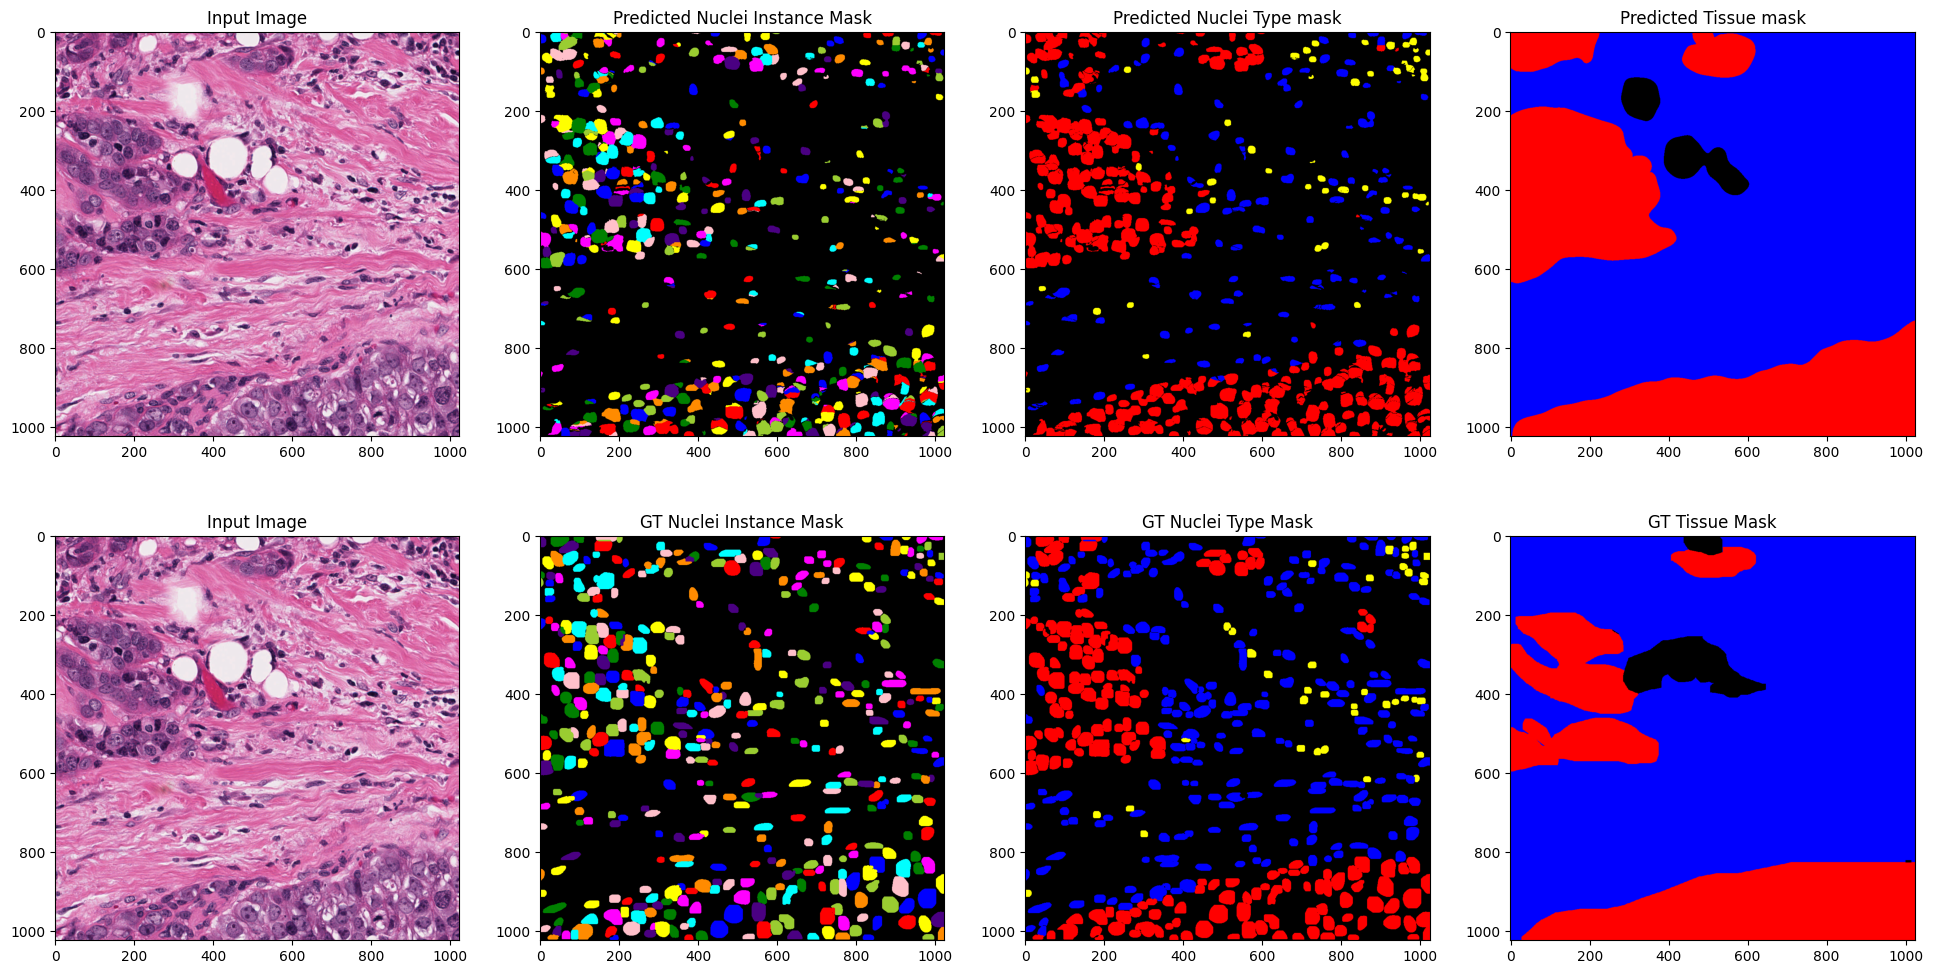

In [17]:
from albumentations import Resize, Compose
from histolytics.models.cellpose_panoptic import CellposePanoptic
from histolytics.transforms import MinMaxNormalization
from matplotlib import pyplot as plt
from skimage.color import label2rgb
from pathlib import Path


model = CellposePanoptic.from_pretrained(
    Path().home()
    / "panoptils_refined"
    / "effnet_cpose_panop_weights_epoch_0.safetensors"
)


model.set_inference_mode()

# Resize to multiple of 32 of your own choosing
transform = Compose([Resize(1024, 1024), MinMaxNormalization()])

ix = 20
im = png_bytes_to_array(df_val.iloc[ix]["image"])
im = transform(image=im)["image"]

prob = model.predict(im)
out = model.post_process(prob)

# Validation 'GT' masks
gt_inst = png_bytes_to_array(df_val.iloc[ix]["inst"])
gt_type = png_bytes_to_array(df_val.iloc[ix]["type"])
gt_sem = png_bytes_to_array(df_val.iloc[ix]["sem"])

fig, ax = plt.subplots(2, 4, figsize=(24, 12))
ax = ax.flatten()
ax[0].imshow(im)
ax[0].set_title("Input Image")
ax[1].imshow(label2rgb(out["nuc"][0][0], bg_label=0))
ax[1].set_title("Predicted Nuclei Instance Mask")
ax[2].imshow(label2rgb(out["nuc"][0][1], bg_label=0))  # type_map
ax[2].set_title("Predicted Nuclei Type mask")
ax[3].imshow(label2rgb(out["tissue"][0], bg_label=0))  # tissue_map
ax[3].set_title("Predicted Tissue mask")
ax[4].imshow(im)
ax[4].set_title("Input Image")
ax[5].imshow(label2rgb(gt_inst, bg_label=0))
ax[5].set_title("GT Nuclei Instance Mask")
ax[6].imshow(label2rgb(gt_type, bg_label=0))
ax[6].set_title("GT Nuclei Type Mask")
ax[7].imshow(label2rgb(gt_sem, bg_label=0))
ax[7].set_title("GT Tissue Mask")

After only one epoch of training we can already see that the model is able to predict the nuclei instance segmentation, nuclei type, and tissue type reasonably reasonably well. In real life you would train the model for more epochs to get better results than in this example.